# Detecção de bordas e limiares em fotografias de fósseis da Formação Ponta Grossa

**Visão Computacional e Percepção - TA1**

**Henrique Luiz Rieger - GRR20190357**

O notebook original e o código-fonte deste relatório encontram-se [nesse repositório](https://github.com/henrieger/ta1-visao).

## Introdução
Este trabalho da disciplina de Visão Computacional e Percepção busca aplicar as técnicas básicas de manipulação de imagens vistas no começo do curso: aplicação de filtros, correções, limiares e detecção de bordas; utilizando como ferramenta a biblioteca OpenCV. Como aplicação prática, é proposta a utilização dessas técnicas em 54 fotografias de fósseis da Formação Ponta Grossa, pertencentes ao acervo do [LABPALEO-UFPR](http://www.labpaleo.ufpr.br). O propósito desta aplicação é testar a viabilidade de utilizar essas ferramentas para resumir as informações dessas imagens a uma matriz binária (os contornos), de forma a posteriormente alimentar classificadores como redes neurais com entradas menores e pré-filtradas. 

## Métodos aplicados
Para possibilitar a obtenção de caracteres nas fotografias de fósseis, diversas técnicas básicas de visão computacional foram aplicadas. Primeiramente, é aplicada uma correção de gama, de forma a tentar ressaltar alguns contornos mais suaves dos fósseis. Depois, é aplicado um filtro bilateral, a fim de reduzir ruídos inerentes ao tipo de fotografia analisada. O resultado do filtro bilateral é então submetido a um limiar (*threshold*) binário, que é usado como máscara na próxima etapa: o algoritmo de Canny em si. Esse é aplicado diretamente à imagem com correção de gama, a fim de preservar o máximo de detalhes, com o auxílio da máscara calculada para eliminar contornos próprios da rocha.

## Implementação
Primeiramente, precisamos importar as bibliotecas que vamos usar para estes experimentos. A célula abaixo importa as bibliotecas NumPy, matplotlib, OpenCV (`cv2`), glob (para manipulação fácil de arquivos) e ipywidgets (para interação).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import glob

import ipywidgets as widgets
from ipywidgets import interact, interactive, IntSlider, FloatSlider

Agora, vamos definir uma função para importar uma imagem como um vetor de números, utilizando a biblioteca OpenCV. A função recebe como entrada um caminho para o arquivo a ser aberto.

In [2]:
def get_img(path: str):
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    return img

Em seguida, utilizando a biblioteca glob, podemos obter uma lista de todos os nomes e caminhos de arquivos `.png` presentes no diretório `img`. Uma pequena prévia destes caminhos é usada para verificar a corretude da função.

In [3]:
samples = glob.glob(r'img/*.png')
samples.sort()
samples[0:5]

['img/Catalogo_fosseis_PontaGrossa-10.png',
 'img/Catalogo_fosseis_PontaGrossa-101.png',
 'img/Catalogo_fosseis_PontaGrossa-102.png',
 'img/Catalogo_fosseis_PontaGrossa-104.png',
 'img/Catalogo_fosseis_PontaGrossa-105.png']

Vamos então definir algumas funções para encapsular as operações da biblioteca OpenCV em chamadas mais simples.

Primeiramente, vamos definir a função `gamma_correction`, que realiza uma correção de gama para iluminar ou escurecer, de maneira exponencial, a imagem. A ideia é revelar características dos espécimes que podem aparecer muito fracamente quanto em uma segunda tentativa de ofuscar ruídos causados pela textura da rocha, ressaltando também as bordas principalmente de fósseis carbonificados (mais escuros em relação à matriz). Caso não seja necessário, é sempre possível definir o valor do coeficiente gama para `1` e manter a imagem inalterada.

In [4]:
def gamma_correction(img, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv.LUT(img, table)

def test_gamma(sample, gamma):
    img = get_img(sample)
    gc = gamma_correction(img, gamma)
    plt.imshow(gc, 'gray')
    
interactive(test_gamma, sample=samples, gamma=FloatSlider(min=0.01, max=5, value=1))

interactive(children=(Dropdown(description='sample', options=('img/Catalogo_fosseis_PontaGrossa-10.png', 'img/…

Agora, definimos a função `bilateral_filter`, que devolve a imagem de entrada com um filtro bilateral aplicado. Esse filtro foi selecionado pois possui a excelente propriedade de eliminar ruídos de alta frequência enquanto mantém a consistência das bordas, sem borrá-las muito. Isto se fez necessário pois a matriz rochosa na qual o fóssil está inserido é bastante irregular, introduzindo muitas sombras e contornos pequenos que atrapalham na detecção das bordas do ser vivo preservado. Dessa forma, podemos eliminar boa parte dessa textura, permitindo que o limiar extraia apenas o fóssil.

In [5]:
def bilateral_filter(img, d, sigma):
    return cv.bilateralFilter(img, d, sigma, sigma)

def test_bilateral(sample, d, sigma):
    img = get_img(sample)
    bl = bilateral_filter(img, d, sigma)
    plt.imshow(bl, 'gray')
    
interactive(
    test_bilateral,
    sample=samples,
    d=IntSlider(min=1, max=10, value=1),
    sigma=IntSlider(min=10, max=250, value=10)
)

interactive(children=(Dropdown(description='sample', options=('img/Catalogo_fosseis_PontaGrossa-10.png', 'img/…

Em seguida, definiremos um limiar binário, que irá atuar como máscara para a aplicação do detector de bordas. O resultado deste limiar pode ser invertido, caso o fóssil seja mais escuro que o restante da imagem.

In [10]:
def threshold(img, thresh, invert=False):
    def inv(img):
        return (255-img)
    new_img = cv.threshold(img, thresh, 255, cv.THRESH_BINARY)[1]
    return inv(new_img) if invert else new_img
    
def test_threshold(sample, thresh):
    img = get_img(sample)
    tsh = threshold(img, thresh)
    inv_tsh = threshold(img, thresh, True)
    fig, axes = plt.subplots(1, 3, figsize=(16,9))
    axes[0].imshow(img, 'gray')
    axes[1].imshow(tsh, 'gray')
    axes[2].imshow(inv_tsh, 'gray')
    
interactive(test_threshold, sample=samples, thresh=IntSlider(min=0, max=255, value=100))

interactive(children=(Dropdown(description='sample', options=('img/Catalogo_fosseis_PontaGrossa-10.png', 'img/…

Por fim, criamos uma função que encapsula o algoritmo de Canny, implementado pela OpenCV. Vale notar que essa implementação não possui um parâmetro de sigma para as gaussianas derivadas, sendo que o nível de detalhamento é definido pelo tamanho do *kernel* utilizado. Na API do OpenCV, esse parâmetro é denominado `aperture`. Também é possível ativar uma função `L2gradient` para normalização das curvas, que é mais precisa que a normalização linear padrão.

In [11]:
def edges(img, minimum, maximum, aperture, l2_gradient):
    return cv.Canny(img, minimum, maximum, apertureSize = aperture, L2gradient=l2_gradient)
    
def test_edges(sample, minimum, maximum, aperture, l2_gradient):
    img = get_img(sample)
    edg = edges(img, minimum, maximum, aperture, l2_gradient)
    plt.imshow(edg, 'gray')
    
interact(test_edges, sample=samples, minimum=(0, 255), maximum=(0, 255), aperture=IntSlider(min=3, max=7, step=2, value=3), l2_gradient=False)

interactive(children=(Dropdown(description='sample', options=('img/Catalogo_fosseis_PontaGrossa-10.png', 'img/…

<function __main__.test_edges(sample, minimum, maximum, aperture, l2_gradient)>

Abaixo, é possível ver os resultados de aplicar o *pipeline* de efeitos completo, e ajustar os parâmetros para obter o resultado desejado. São 9 parâmetros ao todo. 

In [8]:
def generate(sample, d, sigma, gamma, thresh, invert_thresh, edge_min, edge_max, aperture, l2_gradient):
    img = get_img(sample)
    gamma = gamma_correction(img, gamma)
    bl = bilateral_filter(gamma, d, sigma)
    tsh = threshold(bl, thresh, invert_thresh)    
    edg = edges(gamma, edge_min, edge_max, aperture, l2_gradient)
    
    plt.figure(figsize=(16,8))
    
    plt.subplot(231)
    plt.title('Imagem Original')
    plt.xticks([]), plt.yticks([])
    plt.imshow(img, 'gray')
    
    plt.subplot(232)
    plt.title('Gama aplicado')
    plt.xticks([]), plt.yticks([])
    plt.imshow(gamma, 'gray')
    
    plt.subplot(233)
    plt.title('Filtro Bilateral')
    plt.xticks([]), plt.yticks([])
    plt.imshow(bl, 'gray')
    
    plt.subplot(234)
    plt.title('Threshold')
    plt.xticks([]), plt.yticks([])
    plt.imshow(tsh, 'gray')
        
    plt.subplot(235)
    plt.title('Canny')
    plt.xticks([]), plt.yticks([])
    plt.imshow(edg, 'gray')
    
    plt.subplot(236)
    plt.title('Threshold * Canny')
    plt.xticks([]), plt.yticks([])
    plt.imshow(tsh*edg, 'gray')
    
interact(
    generate,
    sample=samples,
    d=IntSlider(min=1, max=10, value=9),
    sigma=IntSlider(min=0, max=250, value=150),
    gamma=FloatSlider(min=0.01, max=5, value=2.2),
    thresh=(0, 255),
    invert_thresh=False,
    edge_min=IntSlider(min=0, max=255, value=100),
    edge_max=IntSlider(min=0, max=255, value=150),
    aperture=IntSlider(min=3, max=7, step=2, value=3),
    l2_gradient=True
)

interactive(children=(Dropdown(description='sample', options=('img/Catalogo_fosseis_PontaGrossa-10.png', 'img/…

<function __main__.generate(sample, d, sigma, gamma, thresh, invert_thresh, edge_min, edge_max, aperture, l2_gradient)>

A função `figure` aplica o mesmo *pipeline* definido anteriormente, mas gerando apenas imagens para fins de demonstração, que podem ser salvas em arquivos. Abaixo, vemos a aplicação dos métodos a um fóssil de Lingulídeo.

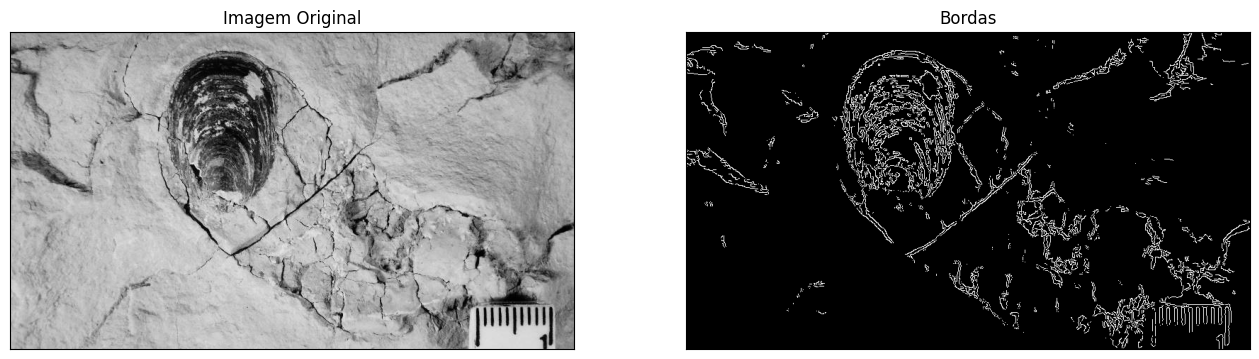

In [9]:
filename = 'teste'

def figure(sample, d, sigma, gamma, thresh, invert_thresh, edge_min, edge_max, aperture, l2_gradient):
    img = get_img(sample)
    gamma = gamma_correction(img, gamma)
    bl = bilateral_filter(gamma, d, sigma)
    tsh = threshold(bl, thresh, invert_thresh)    
    edg = edges(gamma, edge_min, edge_max, aperture, l2_gradient)
    
    plt.figure(figsize=(16,8))
    
    plt.subplot(121)
    plt.title('Imagem Original')
    plt.xticks([]), plt.yticks([])
    plt.imshow(img, 'gray')
    
    plt.subplot(122)
    plt.title('Bordas')
    plt.xticks([]), plt.yticks([])
    plt.imshow(tsh*edg, 'gray')
    
    # plt.savefig(filename)
    
figure('img/Catalogo_fosseis_PontaGrossa-34.png', 9, 150, 0.7, 100, True, 100, 190, 3, True)

## Conclusões

Os métodos de visão computacional permitem simplificar significativamente as imagens de entrada. No entanto, a qualidade dos contornos é variável, sendo altamente dependente do tipo de fóssil e das condições da fotografia. Fósseis carbonificados naturalmente têm alto contraste e, logo, tornam simples a separação deles da matriz rochosa. Por outro lado, réplicas (moldes e impressões) são bastante similares à rocha e a qualidade da detecção de bordas varia conforme o detalhamento do fóssil e a iluminação da fotografia. No mais, os resultados foram satisfatórios.

## Referências e Agradecimentos

As fotos usadas neste trabalho foram generosamente cedidas pelo Prof. Robson Tadeu Bolzon, do Departamento de Geologia da UFPR. Os fósseis retratados são parte do acervo do Laboratório de Paleontologia da UFPR (LABPALEO-UFPR).

Mais informações sobre filtros bilaterais podem ser encontradas na [documentação do OpenCV]() e no site do curso [A Gentle Introduction to Bilateral Filtering and its Applications](http://people.csail.mit.edu/sparis/bf_course/).